# Treasuremap tutorial

All tutorial documentation can be found at http://treasuremap.space/documentation

# Section 1 - Basic API functions

In [1]:
import requests
import urllib.parse
import os, sys, json

#set your api_token here:
BASE = 'http://treasuremap.space/api/v0'
api_token = "abcdefghijYOUR-API-TOKENklmnopqrstuvwxyz"

## Section 1.1 - Querying Pointings
Here we will query all of the pointings for a given event, with various filtering parameters. All of the filtering parameters are described in the API documentatoin page for this GET endpoint

In [2]:
TARGET = 'pointings'

#define the filtering parameters 
#grab all of the completed pointings taken with a specific instrument for a given event

graceid = 'S190425z'
instrument = 'CSS'

params = {
    "api_token":api_token,
    "instrument":instrument,
    "graceid":graceid,
    "status":"completed"
}

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
r = requests.get(url = url)
print("There are %s pointings" % len(json.loads(r.text)))

#print the first
print(json.loads(r.text)[0])

There are 12 pointings
{"id": 4139, "status": "completed", "position": "POINT (-112.788 16.5661)", "galaxy_catalog": "", "galaxy_catalogid": "", "instrumentid": 11, "depth": 21.3, "depth_err": "", "depth_unit": 1, "time": "2019-04-25T09:34:31", "datecreated": "2019-08-19T20:43:10.239772", "dateupdated": "", "submitterid": 3, "pos_angle": 0.0, "band": "open", "doi_url": "", "doi_id": ""}


## Section 1.2 - Querying instruments

In [3]:
TARGET = 'instruments'

# type can be photometric or spectroscopic
params = {
            "api_token":api_token,
            "type":"photometric",
            "name":"ZTF"
        }

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
r = requests.get(url = url)

print("Requested Instrument Info")
print(json.loads(r.text)[0])

Requested Instrument Info
{"id": 47, "instrument_name": "ZTF", "nickname": "None", "instrument_type": "photometric", "datecreated": "2019-10-25T18:06:44.012811", "submitterid": 52}


## Section 1.3 - Submitting planned pointings

In [4]:
TARGET = 'pointings'

#To post pointings you need to first declare the LIGO Gravitational graceid
graceid = 'TEST_EVENT'

#Set some parameters
ra, dec='256.','-12.'
time='2019-11-11T5:45:00.00'
instrumentid="11"

pointings = [
    {
        "status":"planned",
        "position":"POINT("+ra+" "+dec+")",
        "instrumentid":instrumentid,
        "pos_angle":20.0,
        "time":time,
        "band":"open",
        "depth":21.5,
        "depth_unit":'ab_mag'
    }
]

json_data = {
    "graceid":graceid,
    "api_token":api_token,
    "pointings":pointings
}
r = requests.post(url = BASE+'/'+TARGET, json = json_data)
print(r.text)

{"ERRORS":[],"WARNINGS":[],"pointing_ids":[13618]}



## Section 1.4 - Submitting completed pointings

In [5]:
TARGET = 'pointings'

#To post pointings you need to first declare the LIGO Gravitational graceid
graceid = "TEST_EVENT"

#Set some parameters
ra,dec='257.','-12.'
time='2019-11-11T12:20:51.00'
instrumentid="11"

pointings = [
    {
        "status":"completed",
        "position":"POINT("+ra+" "+dec+")",
        "instrumentid":instrumentid,
        "pos_angle":0.0,
        "time":time,
        "band":"open",
        "depth":21.5,
        "depth_unit":'ab_mag'
    }
]

json_data = {
    "graceid":graceid,
    "api_token":api_token,
    "pointings":pointings
}
r = requests.post(url = BASE+'/'+TARGET, json = json_data)
print(r.text)

{"ERRORS":[],"WARNINGS":[],"pointing_ids":[13619]}



# Section 2. Other API features

## Section 2.1 Cancelling Planned Pointings
There are two methods for cancelling planned pointings
* Cancelling based on IDs
* Cancelling all planned pointings for a given event

### Cancelling based on IDs

In [6]:
TARGET = 'update_pointings'

#specify your list of IDs
ids = [13613]

params = {
    "api_token":api_token,
    "ids":ids,
    "status":"cancelled"
}

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))

r = requests.post(url = url)
print(r.text)

 ### Cancelling all planned pointings for a given event

In [7]:
TARGET = 'cancel_all'

#Required are the graceid and instrumentID
graceid = 'TEST_EVENT'
instrument = 11

params = {
    "api_token":api_token,
    "graceid":graceid,
    "instrumentid":instrument
}

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))

r = requests.post(url = url)
print(r.text)

## Section 2.1 - Requesting DOI for completed pointings
There are various ways to request a DOI for your completed pointings. 
* DOI's can be requested upon posting your pointings
* DOI's can be requested after successfully posting your completed pointings.
Once a DOI is posted, it cannot be removed. Thus in order to remove clutter, having multiple pointings associated to a single DOI is the ideal approach to this functionality.

The authors for the DOI can be specified one of two ways.
* As json list of:
    * name\*, affiliation\*, orcid, gnd
* A doi_author group can be created on your user profile page and be referenced by ID or name via *doi_group_id*
    * \***denotes required**

### Requesting for a single GW Event

In [8]:
TARGET = 'request_doi'

#Please don't request a doi for TEST_EVENT
graceid = 'TEST_EVENT'
creators = [
    {"name":"Name1", "affiliation":"affil_1"},
    {"name":"Name2", "affiliation":"affil_2"}
]

json_data = {
    "api_token":api_token,
    "graceid":graceid,
    "creators":creators
}

r = requests.post(url = BASE+'/'+TARGET, json = json_data)
print(r.text)

### Requesting from completed pointing ID

In [9]:
TARGET = 'request_doi'

#specify a list of ids
ids = [11356]
#doi group id from creating one on your profile page
doi_group_id = 23

json_data = {
    "api_token":"abcdefghijkl",
    "ids":ids,
    "doi_group_id":doi_group_id
}

r = requests.post(url = BASE+'/'+TARGET, json = json_data)
print(r.text)

## Section 2.3 Getting Instrument Information

In [10]:
#Using this function to convert the string Polygons to a list of points
def sanatize_footprint_ccds(ccds):
    footprint_ccds = []
    for footprint in ccds:
        sanitized = footprint.strip('POLYGON ').strip(')(').split(',')
        polygon = []
        for vertex in sanitized:
            obj = vertex.split()
            ra = float(obj[0])
            dec = float(obj[1])
            polygon.append([ra,dec])
        footprint_ccds.append(polygon)
    return footprint_ccds

Requested Footprint Info


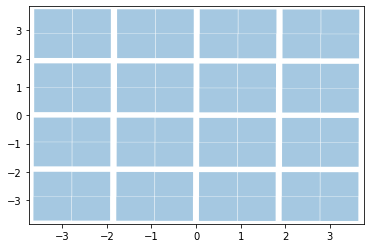

In [12]:
# Getting Instrument Footprint
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

TARGET = 'footprints'

params = {
            "api_token":api_token,
            "name":"ZTF"
        }

url = "{}/{}?{}".format(BASE, TARGET, urllib.parse.urlencode(params))
r = requests.get(url = url)

print("Requested Footprint Info")

footprints = json.loads(r.text)
polygons = []
patches = []

#This gets all of the Polygon information from the json list
for f in footprints:
    f_info = json.loads(f)
    polygons.append(f_info['footprint'])

#converts the polygons to a list of list of points (list of polygons)
sanatized_ccds = sanatize_footprint_ccds(polygons)

#gather the points for ylim and xlim
xs, ys = [], []

for sc in sanatized_ccds:
    #add the polygon list of points to the matplotlib patch collection
    patches.append(Polygon(sc, True))
    for p in sc:
        xs.append(p[0])
        ys.append(p[1])
    
p = PatchCollection(patches, alpha=0.4)

fig, ax = plt.subplots()
ax.set_xlim(min(xs)-.1, max(xs)+.1)
ax.set_ylim(min(ys)-.1, max(ys)+.1)
ax.add_collection(p)
plt.show()